- Overview of example system with data interfaces
- air source heat pump
- What inputs/information do we need? e.g. COP, demand time series, price electricity, ...
- How can we generate those inputs


![solph graph](./workshop/figures/energy_system_solph.svg)


In [11]:
from workshop.model.utilities import load_input_data

input_data = load_input_data()

result_dict = {}


In [12]:
import oemof.solph as solph

def create_energy_system_stub(input_data):
    es = solph.EnergySystem(timeindex=input_data.index, infer_last_interval=False)

    bus_electricity = solph.Bus(label="electricity")
    bus_heat_35C = solph.Bus(label="heat 35C")

    es.add(bus_electricity, bus_heat_35C)

    electricity_grid = solph.components.Source(
        label="electricity grid",
        outputs={bus_electricity: solph.Flow(variable_costs=0.4)},  # €/kWh
    )

    thermal_storage = solph.components.GenericStorage(
        label='thermal storage',
        inputs={bus_heat_35C: solph.Flow()},
        outputs={bus_heat_35C: solph.Flow()},
        loss_rate=0.02,
        nominal_storage_capacity=8.7,  # Assume 5 k of spread and 1.5 m³ volume
    )

    demand = input_data["Heat load (kW)"][:-1]

    heat_demand = solph.components.Sink(
        label="heat demand",
        inputs={bus_heat_35C: solph.Flow(nominal_value=1, fix=demand)},  # kW
    )


    es.add(electricity_grid, thermal_storage, heat_demand)

    return es, bus_electricity, bus_heat_35C

Example heat pump: https://www.viessmann.co.uk/en/products/heat-pump/vitocal-150a.html (type 150.A16)

In [13]:
hp_thermal_power = 9.1  # kW
cop_a7_w35 = 4.9

In [14]:
es, bus_electricity, bus_heat_35C = create_energy_system_stub(input_data=input_data.head(24*2))

heat_pump_constant = solph.components.Converter(
    label="heat pump",
    inputs={bus_electricity: solph.Flow()},
    outputs={bus_heat_35C: solph.Flow(nominal_value=hp_thermal_power)},
    conversion_factors={
        bus_electricity: 1,
        bus_heat_35C: cop_a7_w35,
    },
)


es.add(heat_pump_constant)


model_constant = solph.Model(energysystem=es)
model_constant.solve()


result_dict["constant"] = solph.processing.results(model_constant)

Electricity demand: 15.5 kWh


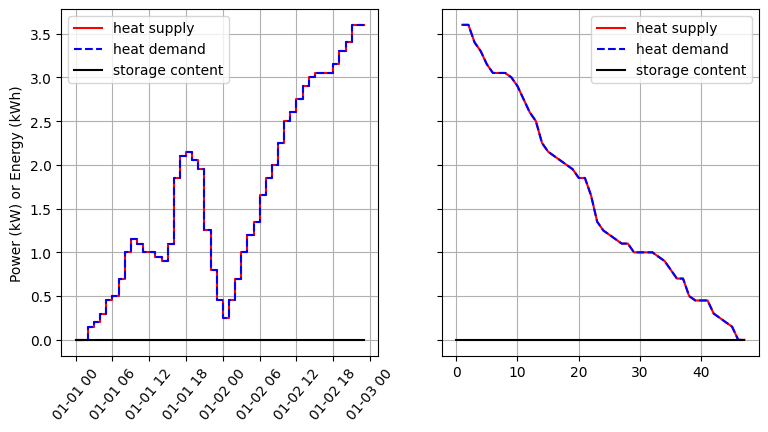

In [15]:

import numpy as np
import matplotlib.pyplot as plt

def sumarise_results(results):
    results = solph.views.convert_keys_to_strings(results)

    heat_supply = results[("heat pump", "heat 35C")]["sequences"]["flow"]
    storage_content = results[("thermal storage", "None")]["sequences"]["storage_content"]
    demand = results[("heat 35C", "heat demand")]["sequences"]["flow"]

    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9, 4.5))

    ax1.plot(heat_supply, "r-", label="heat supply", drawstyle="steps-post")
    ax1.plot(demand, "b--", label="heat demand", drawstyle="steps-post")
    ax1.plot(storage_content, "k-", label="storage content")
    ax1.set_ylabel("Power (kW) or Energy (kWh)")
    ax1.tick_params(axis="x", rotation=50)
    ax1.grid()
    ax1.legend()

    ax2.plot(np.sort(heat_supply)[::-1], "r-", label="heat supply")
    ax2.plot(np.sort(demand)[::-1], "b--", label="heat demand")
    ax2.plot(np.sort(storage_content)[::-1], "k-", label="storage content")
    ax2.grid()
    ax2.legend()

    electricity_consumption = float(results[("electricity grid", "electricity")]["sequences"].sum())
    print(f"Electricity demand: {electricity_consumption:.1f} kWh")

sumarise_results(result_dict["constant"])

Temperature-dependent COP

![solph graph](./workshop/figures/heat_pump_blackbox_comparison.svg)

- COP depends on temperature, we only know a single temperature value
- Solution: Use Carnot method with constant efficiency assumption
- Reference temperature for Carnot COP is unclear, 7°C -> 35°C vs. 2°C -> 40°C

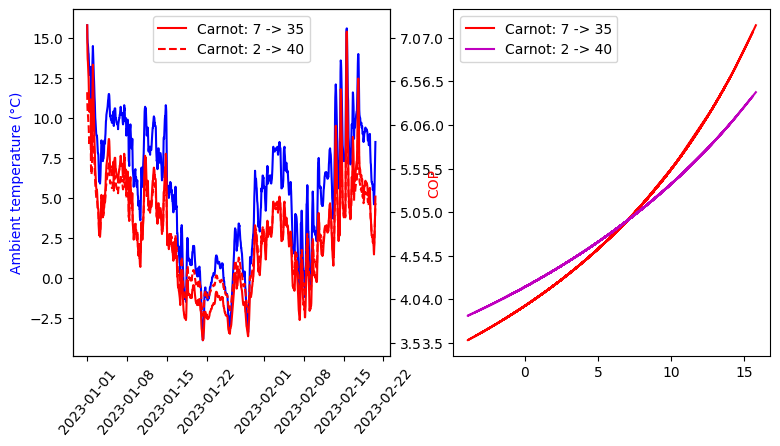

In [16]:
carnot_cop_7_35 = (35+273.15) / (35-7)
cpf_7_35 = cop_a7_w35 / carnot_cop_7_35

carnot_cop_2_40 = (40+273.15) / (40-2)
cpf_2_40 = cop_a7_w35 / carnot_cop_2_40

input_data["cpf COP 7 -> 35"] = cpf_7_35 * (35+273.15) / (35 - input_data["Ambient temperature (°C)"])
input_data["cpf COP 2 -> 40"] = cpf_2_40 * (40+273.15) / (40 - input_data["Ambient temperature (°C)"] + 5)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

ax1.plot(input_data["Ambient temperature (°C)"], "b-")
ax1.set_ylabel("Ambient temperature (°C)").set_color("blue")


ax1.tick_params(axis="x", rotation=50)
ax1.twinx()

plt.plot(input_data["cpf COP 7 -> 35"], "r-", label="Carnot: 7 -> 35")
plt.plot(input_data["cpf COP 2 -> 40"], "r--", label="Carnot: 2 -> 40")
plt.ylabel("COP").set_color("red")
plt.legend()

ax2.plot(
    input_data["Ambient temperature (°C)"],
    input_data["cpf COP 7 -> 35"],
    "r-",
    label="Carnot: 7 -> 35",
)
ax2.plot(
    input_data["Ambient temperature (°C)"],
    input_data["cpf COP 2 -> 40"],
    "m-",
    label="Carnot: 2 -> 40",
)
ax2.legend()

plt.show()

Electricity demand: 14.1 kWh


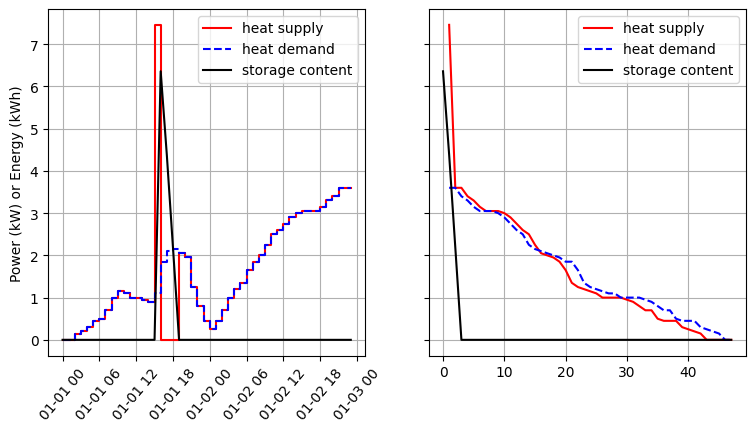

In [17]:
es, bus_electricity, bus_heat_35C = create_energy_system_stub(input_data=input_data.head(24*2))

heat_pump_carnot = solph.components.Converter(
    label="heat pump",
    inputs={bus_electricity: solph.Flow()},
    outputs={bus_heat_35C: solph.Flow(nominal_value=hp_thermal_power)},
    conversion_factors={
        bus_electricity: 1,
        bus_heat_35C: input_data["cpf COP 2 -> 40"][:-1],
    },
)

es.add(heat_pump_carnot)


model_carnot = solph.Model(energysystem=es)
model_carnot.solve()


result_dict["carnot"] = solph.processing.results(model_carnot)
sumarise_results(result_dict["carnot"])

- Then TESPy model to generate COP, reconfigure the heat pump in solph and run again.

Electricity demand: 14.0 kWh


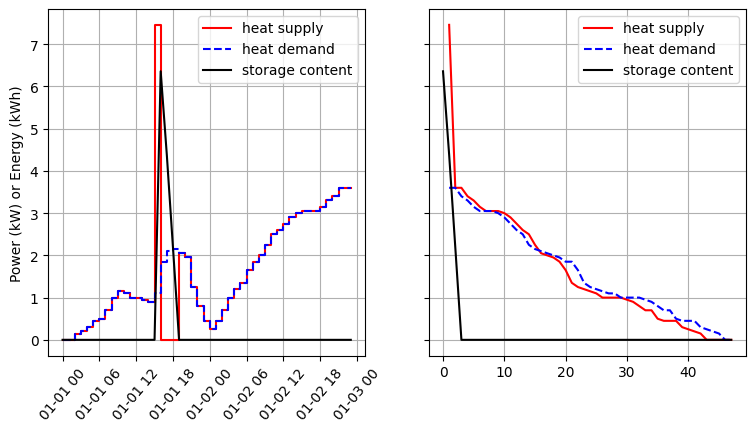

In [18]:
from workshop.model.utilities import load_tespy_cop

tespy_cop = load_tespy_cop()

input_data["simple TESPy COP"] = input_data["Ambient temperature (d°C)"].map(tespy_cop["COP"])

es, bus_electricity, bus_heat_35C = create_energy_system_stub(input_data=input_data.head(24*2))

heat_pump_tespy = solph.components.Converter(
    label="heat pump",
    inputs={bus_electricity: solph.Flow()},
    outputs={bus_heat_35C: solph.Flow(nominal_value=hp_thermal_power)},
    conversion_factors={
        bus_electricity: 1,
        bus_heat_35C: input_data["simple TESPy COP"][:-1],
    },
)

es.add(heat_pump_tespy)


model_tespy = solph.Model(energysystem=es)
model_tespy.solve()


result_dict["tespy"] = solph.processing.results(model_tespy)

sumarise_results(result_dict["tespy"])

Introduce minimal load, reconfigure heat pump for that, rerun and make plots.

Electricity demand: 14.2 kWh


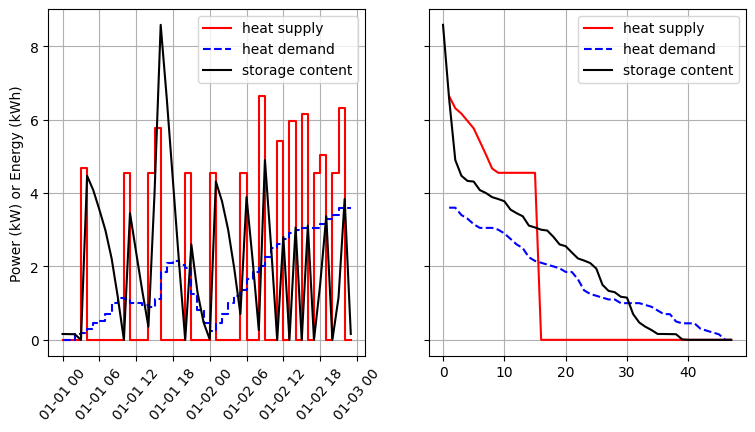

In [19]:
from workshop.model.utilities import load_tespy_cop

tespy_cop = load_tespy_cop()

input_data["simple TESPy COP"] = input_data["Ambient temperature (d°C)"].map(tespy_cop["COP"])

es, bus_electricity, bus_heat_35C = create_energy_system_stub(input_data=input_data.head(24*2))

heat_pump_nonconvex = solph.components.Converter(
    label="heat pump",
    inputs={bus_electricity: solph.Flow()},
    outputs={bus_heat_35C: solph.Flow(
        nominal_value=hp_thermal_power,
        nonconvex=solph.NonConvex(),
        min=0.5,
    )},
    conversion_factors={
        bus_electricity: 1,
        bus_heat_35C: input_data["simple TESPy COP"][:-1],
    },
)

es.add(heat_pump_nonconvex)


model_nonconvex = solph.Model(energysystem=es)
model_nonconvex.solve()


result_dict["nonconvex"] = solph.processing.results(model_nonconvex)
sumarise_results(result_dict["nonconvex"])

Get part load dependent COP from TESPy, reconfigure heat pump, rerun and make plots.

Electricity demand: 14.3 kWh


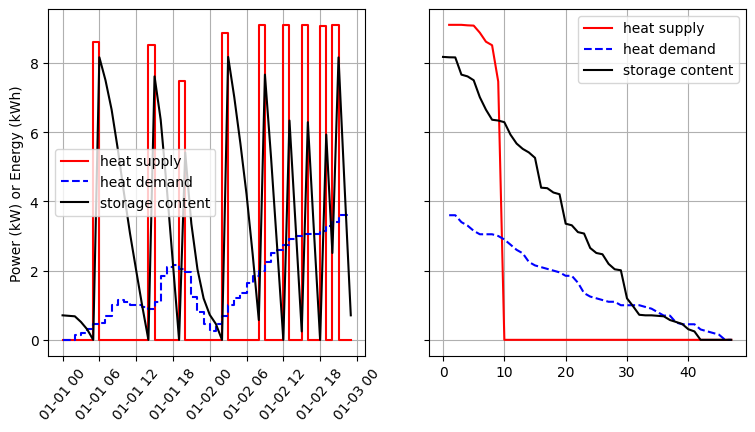

In [20]:
from workshop.model.utilities import load_tespy_coefficients

tespy_coefficients = load_tespy_coefficients()

input_data["slope"] = input_data["Ambient temperature (d°C)"].map(tespy_coefficients["slope"])
input_data["offset"] = input_data["Ambient temperature (d°C)"].map(tespy_coefficients["offset"])
slope = input_data["slope"]
offset = input_data["offset"]

es, bus_electricity, bus_heat_35C = create_energy_system_stub(input_data=input_data.head(24*2))

heat_pump = solph.components.OffsetConverter(
        label=f"heat pump",
        inputs={bus_electricity: solph.Flow()},
        outputs={
            bus_heat_35C: solph.Flow(
                nominal_value=hp_thermal_power,
                nonconvex=solph.NonConvex(),
                min=0.5,
            )
        },
        conversion_factors={bus_electricity: slope},
        normed_offsets={bus_electricity: offset}
)

es.add(heat_pump)

model_offset = solph.Model(energysystem=es)
model_offset.solve()


result_dict["offset"] = solph.processing.results(model_offset)
sumarise_results(result_dict["offset"])